In [2]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as sm
import seaborn as sns
from functools import reduce
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
import scipy.signal

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We only have zhvi for the current month. In case of missing data (Some data are only available for large-size areas), we only predict top 20 size counties.
Fitting time series: example of los
Predict and compare with the next period.

prediction time horizon: from 2011-03 to 2018-10: since we only have mortgage fixed rate starting from 2011-3

We only have zillow zhvi forcast on 2018-11 at the time we start our project.

## Read Median ZHVI 

In [6]:
median_zhvi['RegionName'][:20]

0        Los Angeles County
1               Cook County
2             Harris County
3           Maricopa County
4          San Diego County
5             Orange County
6              Kings County
7         Miami-Dade County
8             Dallas County
9             Queens County
10         Riverside County
11    San Bernardino County
12             Clark County
13              King County
14             Wayne County
15           Tarrant County
16       Santa Clara County
17           Broward County
18             Bexar County
20      Philadelphia County
Name: RegionName, dtype: object

In [5]:
path = '/Users/liusulin/Desktop/Data Science/Project2/'
median_zhvi = pd.read_csv(path + 'County_MedianValuePerSqft_AllHomes.csv',
                         encoding = "ISO-8859-1").dropna()
# len(median_zhvi['RegionName'].unique()
# median_zhvi.drop_duplicates()
#calcualte return
# median_zhvi['return'] = 100 * (median_zhvi['2017-12']-median_zhvi['2016-12'])/median_zhvi['2016-12']
median_zhvi

,RegionID,RegionName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,SizeRank,1996-04,1996-05,1996-06,...,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10
0,3101,Los Angeles County,CA,Los Angeles-Long Beach-Anaheim,6,37,1,114.0,114.0,113.0,...,411,415,417,418,419,419,420,420,421,423
1,139,Cook County,IL,Chicago-Naperville-Elgin,17,31,2,102.0,103.0,104.0,...,163,165,165,166,166,166,167,167,167,167
2,1090,Harris County,TX,Houston-The Woodlands-Sugar Land,48,201,3,51.0,51.0,51.0,...,94,95,96,96,97,97,97,98,98,98
3,2402,Maricopa County,AZ,Phoenix-Mesa-Scottsdale,4,13,4,62.0,62.0,62.0,...,147,149,150,150,151,152,153,154,155,156
4,2841,San Diego County,CA,San Diego-Carlsbad,6,73,5,104.0,104.0,103.0,...,360,364,367,368,368,367,368,370,371,371
5,1286,Orange County,CA,Los Angeles-Long Beach-Anaheim,6,59,6,116.0,116.0,115.0,...,412,414,416,417,418,420,421,423,423,423
6,581,Kings County,NY,New York-Newark-Jersey City,36,47,7,126.0,126.0,126.0,...,575,580,584,587,590,593,594,594,596,598
7,2964,Miami-Dade County,FL,Miami-Fort Lauderdale-West Palm Beach,12,86,8,66.0,67.0,67.0,...,188,190,191,192,193,195,197,197,198,200
8,978,Dallas County,TX,Dallas-Fort Worth-Arlington,48,113,9,53.0,52.0,53.0,...,112,114,115,116,117,118,119,120,121,122
9,1347,Queens County,NY,New York-Newark-Jersey City,36,81,10,125.0,125.0,126.0,...,481,485,488,492,497,500,501,502,503,505


In [7]:
# median_zhvi['return'] = 100 * (median_zhvi.iloc[:,-1]-median_zhvi.iloc[:,-2])/median_zhvi.iloc[:,-2]
zhvi2 = median_zhvi.set_index(['RegionID', 'RegionName', 'State', 
                       'StateCodeFIPS', 'MunicipalCodeFIPS','SizeRank', 'Metro'])
zhvi_final = zhvi2.T.iloc[:,:20]
zhvi_final = zhvi_final.pct_change()
zhvi_final

RegionID,3101,139,1090,2402,2841,1286,581,2964,978,1347,2832,3250,445,207,791,2049,3136,1561,386,3175
RegionName,Los Angeles County,Cook County,Harris County,Maricopa County,San Diego County,Orange County,Kings County,Miami-Dade County,Dallas County,Queens County,Riverside County,San Bernardino County,Clark County,King County,Wayne County,Tarrant County,Santa Clara County,Broward County,Bexar County,Philadelphia County
State,CA,IL,TX,AZ,CA,CA,NY,FL,TX,NY,CA,CA,NV,WA,MI,TX,CA,FL,TX,PA
StateCodeFIPS,6,17,48,4,6,6,36,12,48,36,6,6,32,53,26,48,6,12,48,42
MunicipalCodeFIPS,37,31,201,13,73,59,47,86,113,81,65,71,3,33,163,439,85,11,29,101
SizeRank,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21
Metro,Los Angeles-Long Beach-Anaheim,Chicago-Naperville-Elgin,Houston-The Woodlands-Sugar Land,Phoenix-Mesa-Scottsdale,San Diego-Carlsbad,Los Angeles-Long Beach-Anaheim,New York-Newark-Jersey City,Miami-Fort Lauderdale-West Palm Beach,Dallas-Fort Worth-Arlington,New York-Newark-Jersey City,Riverside-San Bernardino-Ontario,Riverside-San Bernardino-Ontario,Las Vegas-Henderson-Paradise,Seattle-Tacoma-Bellevue,Detroit-Warren-Dearborn,Dallas-Fort Worth-Arlington,San Jose-Sunnyvale-Santa Clara,Miami-Fort Lauderdale-West Palm Beach,San Antonio-New Braunfels,Philadelphia-Camden-Wilmington
1996-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-05,0.000000,0.009804,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,-0.018868,0.000000,0.000000,0.000000,0.000000,-0.010101,0.000000,0.000000,0.006329,0.000000,0.000000,0.000000
1996-06,-0.008772,0.009709,0.000000,0.000000,-0.009615,-0.008621,0.000000,0.000000,0.019231,0.008000,-0.014493,0.000000,0.000000,0.000000,0.018182,0.018182,0.000000,0.000000,-0.018519,0.000000
1996-07,0.000000,0.000000,0.000000,0.016129,-0.009709,0.000000,0.007937,0.000000,0.000000,0.000000,0.000000,-0.014286,0.000000,0.010204,0.000000,0.000000,0.000000,0.000000,0.000000,-0.026316


### Read increase and decrease

In [8]:
decrease = pd.read_csv(path + 'County_PctOfHomesDecreasingInValues_AllHomes.csv')
decrease_final = decrease.T

In [9]:
increase = pd.read_csv(path + 'County_PctOfHomesIncreasingInValues_AllHomes.csv')
increase_final = increase.T

### Read sales

In [10]:
sales = pd.read_csv(path + 'Sale_Counts_Seas_Adj_County.csv')
sales_final = sales.T

### Read listed price

In [11]:
listprice = pd.read_csv(path + 'County_MedianListingPricePerSqft_AllHomes.csv',encoding = "ISO-8859-1")
listprice_final = listprice.T


### Read price-to-income ratio (Affordability)

In [12]:
afford = pd.read_csv(path + 'Affordability_Wide_2018Q3_Public.csv')
afford_final = afford.T

### Read conventional 30-year fixed mortgage rate

In [13]:
mortrate = pd.read_csv(path + 'MortgageRateConventionalFixed.csv')
mortrate
mortrate['Date'] = pd.to_datetime(mortrate['Date'])
mortrate
# pd.to_datetime(pd.Series(['05/23/2005']))
mortrate = mortrate.resample('M', on='Date').mean()
mortrate['MortgageRateConventionalFixed']

Date
2011-06-30    4.374217
2011-07-31    4.460115
2011-08-31    4.127827
2011-09-30    3.963005
2011-10-31    4.035497
2011-11-30    3.941695
2011-12-31    3.850040
2012-01-31    3.815944
2012-02-29    3.808313
2012-03-31    3.931269
2012-04-30    3.854425
2012-05-31    3.726780
2012-06-30    3.636111
2012-07-31    3.538631
2012-08-31    3.546775
2012-09-30    3.424189
2012-10-31    3.412509
2012-11-30    3.369448
2012-12-31    3.356854
2013-01-31    3.487629
2013-02-28    3.569638
2013-03-31    3.585903
2013-04-30    3.434991
2013-05-31    3.618517
2013-06-30    4.115854
2013-07-31    4.391345
2013-08-31    4.454498
2013-09-30    4.410115
2013-10-31    4.126553
2013-11-30    4.210899
                ...   
2016-07-31    3.464010
2016-08-31    3.415802
2016-09-30    3.416885
2016-10-31    3.478094
2016-11-30    3.803021
2016-12-31    4.111925
2017-01-31    4.036052
2017-02-28    4.014572
2017-03-31    4.081460
2017-04-30    3.892417
2017-05-31    3.881046
2017-06-30    3.789621
2017-0

### Forecast

In [14]:
forecast = pd.read_excel(path + 'zillow_forecast_sizetop20.xlsx')

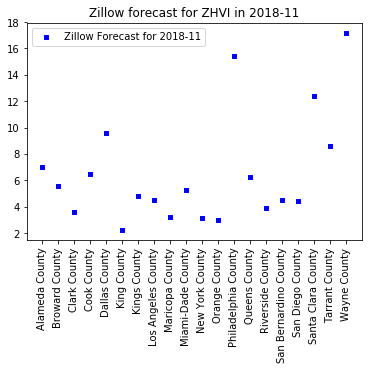

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(forecast['RegionName'], forecast['ForecastYoYPctChange'], s=10, c='b', marker="s", label='Zillow Forecast for 2018-11')
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.title('Zillow forecast for ZHVI in 2018-11')
plt.show()

## An example of Cook County (Chicago)

In [16]:
start = 90 # from 2011-3
start_test = 30
y = zhvi_final.iloc[-start:,1]
x1 = decrease_final.iloc[-start:,1].values
x2 = increase_final.iloc[-start:,1].values
x3 = sales_final.iloc[-start:,1].values
x4 = listprice_final.iloc[-start:,1].values
x5 = afford_final.iloc[-start:,1].values
x6 = mortrate['MortgageRateConventionalFixed'][-start:].values

In [17]:
X = pd.DataFrame({'zhvi':y,
                'decrease':x1,
                 'increase': x2,
                 'sales': x3,
                 'listprice':x4,
                 'affordability':x5,
                 'mortgageRate': x6})
X[['decrease','increase', 'listprice', 'sales', 'affordability', 'mortgageRate']] = X[['decrease','increase', 'listprice', 'sales', 'affordability', 'mortgageRate']].astype(float)

In [18]:
X

,affordability,decrease,increase,listprice,mortgageRate,sales,zhvi
2011-05,3.183125,90.17,6.65,158.267370,4.460115,5126.0,0.000000
2011-06,3.127580,90.78,6.33,157.722767,4.127827,4761.0,-0.007634
2011-07,3.026675,90.68,6.47,154.935040,3.963005,4701.0,-0.015385
2011-08,2.925175,90.17,6.82,151.892497,4.035497,4680.0,0.000000
2011-09,2.824410,90.00,6.86,150.413687,3.941695,4444.0,-0.007812
2011-10,2.734794,89.36,7.33,146.992654,3.850040,4391.0,-0.007874
2011-11,2.721727,88.57,7.86,142.195122,3.815944,4538.0,-0.007937
2011-12,2.778523,87.41,8.59,138.282387,3.808313,4778.0,-0.008000
2012-01,2.836001,85.97,9.76,137.223494,3.931269,5347.0,-0.008065
2012-02,2.889842,85.32,10.17,137.464286,3.854425,5729.0,-0.016260


In [20]:
# add seasonal dummy variables
X['Date'] = X.index
X['Month'] = pd.DatetimeIndex(X['Date']).month
X
seasonal = pd.get_dummies(X, columns=['Month']) 
X = seasonal.drop(['Date', 'Month_1'], axis =1) # we should drop month1 to avoid multicollinearity

In [21]:
X

,affordability,decrease,increase,listprice,mortgageRate,sales,zhvi,Month_2,Month_3,Month_4,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
2011-05,3.183125,90.17,6.65,158.267370,4.460115,5126.0,0.000000,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2011-06,3.127580,90.78,6.33,157.722767,4.127827,4761.0,-0.007634,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2011-07,3.026675,90.68,6.47,154.935040,3.963005,4701.0,-0.015385,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2011-08,2.925175,90.17,6.82,151.892497,4.035497,4680.0,0.000000,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2011-09,2.824410,90.00,6.86,150.413687,3.941695,4444.0,-0.007812,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2011-10,2.734794,89.36,7.33,146.992654,3.850040,4391.0,-0.007874,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2011-11,2.721727,88.57,7.86,142.195122,3.815944,4538.0,-0.007937,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2011-12,2.778523,87.41,8.59,138.282387,3.808313,4778.0,-0.008000,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2012-01,2.836001,85.97,9.76,137.223494,3.931269,5347.0,-0.008065,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-02,2.889842,85.32,10.17,137.464286,3.854425,5729.0,-0.016260,1,0,0,...,0,0,0,0,0,0,0,0,0,0


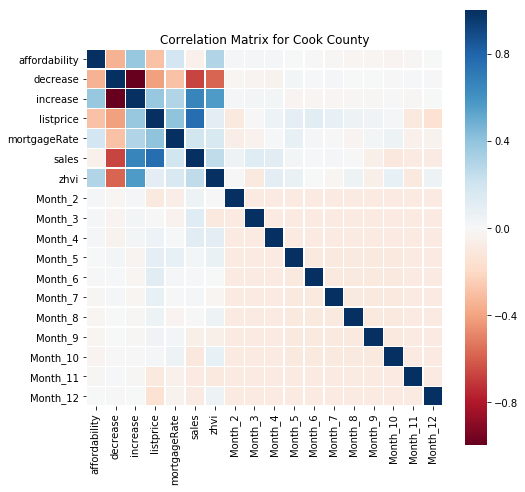

In [37]:
Xcorr = X.corr()
Xcorr
plt.figure(figsize=(8,8))
plt.title('Correlation Matrix for Cook County')
sns.heatmap(Xcorr, fmt='.6f', linewidth = .5, square = True, cmap = 'RdBu')
plt.show()

In [24]:
#split train and test set
X_train = X[:(start -start_test)]
X_test = X[-start_test:]

In [26]:
def OLS(X):
    y = X['zhvi'].astype(float)
    x = X[['decrease','increase', 'listprice', 
           'sales', 'affordability', 'mortgageRate',
          'Month_2', 'Month_3','Month_4','Month_5','Month_6',
          'Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']].astype(float)
    result = sm.OLS(y, x).fit()
    pred = result.predict(x)
    return pred 

In [42]:
np.corrcoef(X_train_pred,X_train_real)

array([[ 1.        ,  0.69669464],
       [ 0.69669464,  1.        ]])

In [41]:
np.corrcoef(X_test_pred,X_test_real)

array([[ 1.        ,  0.88670395],
       [ 0.88670395,  1.        ]])

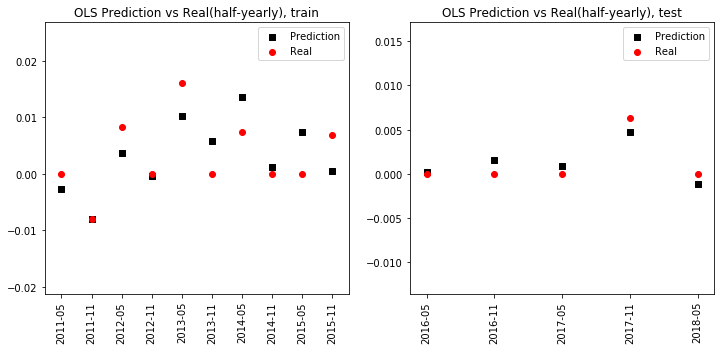

In [27]:
X_train_pred = OLS(X_train)[::6]
X_train_real = zhvi_final.iloc[-start:-start_test,1][::6]
xtrain = X_train_pred.index

X_test_pred = OLS(X_test)[::6]
X_test_real = zhvi_final.iloc[-start_test:,1][::6]
xtest = X_test_pred.index

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(xtrain, X_train_pred,color='black',marker='s',label='Prediction')
plt.scatter(xtrain, X_train_real,color='Red',marker = 'o',label='Real')
plt.xticks(rotation=90)
plt.title('OLS Prediction vs Real(half-yearly), train')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(xtest, X_test_pred,color='black',marker='s',label='Prediction')
plt.scatter(xtest, X_test_real,color='Red',marker = 'o',label='Real')
plt.xticks(rotation=90)
plt.title('OLS Prediction vs Real(half-yearly), test')
plt.legend()

plt.show()

In [96]:
# models = sm.OLS(X.iloc[:,-1], X.iloc[:,:-1])
y = X['zhvi'].astype(float)
x = X[['decrease','increase', 'listprice', 'sales', 'affordability', 'mortgageRate']].astype(float)
result = sm.OLS(y, x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   zhvi   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     12.09
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           9.41e-10
Time:                        20:30:05   Log-Likelihood:                 353.14
No. Observations:                  90   AIC:                            -694.3
Df Residuals:                      84   BIC:                            -679.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
decrease      -8.134e-05   8.76e-05     -0.928      0.356      -0.000    9.29e-05
increase       7.984e-05      0.000      0.691      0.492      -0.000       0.000
listprice      1.256e-05   5.29e-05      0.237      0.813   -9.27e-05       0.000
sales         -8.997e-07    1.1e-06     -0.814      0.418    -3.1e-06     1.3e-06
affordability     0.0012      0.001      0.924      0.358      -0.001       0.004
mortgageRate      0.0004      0.002      0.182      0.856      -0.004       0.004
==============================================================================
Omnibus:                        0.656   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.720   Jarque-Bera (JB):                0.636
Skew:                           0.196   Prob(JB):                        0.728
Kurtosis:                       2.876   Cond. No.                     2.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
def randomForest(X):
    y = X['zhvi'].astype(float)
    x = X[['decrease','increase', 'listprice', 
           'sales', 'affordability', 'mortgageRate',
          'Month_2', 'Month_3','Month_4','Month_5','Month_6',
          'Month_7','Month_8','Month_9','Month_10','Month_11','Month_12']].astype(float)
    forest = RandomForestRegressor(max_depth=3, random_state=0,n_estimators=6,
                                   min_samples_leaf = 5)
    res = forest.fit(x, y)
    pred = res.predict(x)
    return pred

In [49]:
np.corrcoef(X_train_predrf,X_train_real)

array([[ 1.        ,  0.67062471],
       [ 0.67062471,  1.        ]])

In [50]:
np.corrcoef(X_test_predrf,X_test_real)

array([[ 1.        ,  0.85531111],
       [ 0.85531111,  1.        ]])

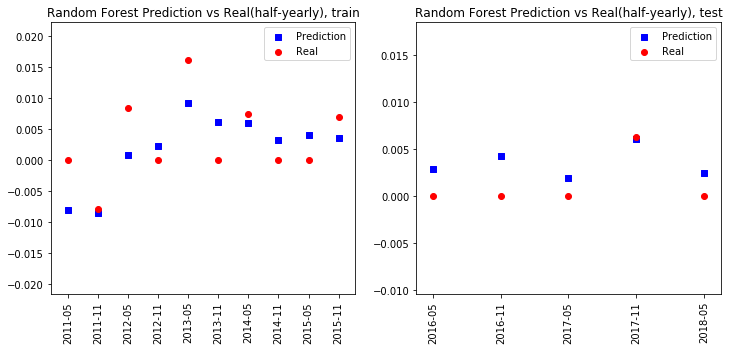

In [48]:
X_train_predrf = randomForest(X_train)[::6]
X_train_real = zhvi_final.iloc[-start:-start_test,1][::6]
xtrain = X_train_pred.index

X_test_predrf = randomForest(X_test)[::6]
X_test_real = zhvi_final.iloc[-start_test:,1][::6]
xtest = X_test_pred.index

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(xtrain, X_train_predrf,color='blue',marker='s',label='Prediction')
plt.scatter(xtrain, X_train_real,color='Red',marker = 'o',label='Real')
plt.xticks(rotation=90)
plt.title('Random Forest Prediction vs Real(half-yearly), train')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(xtest, X_test_predrf,color='blue',marker='s',label='Prediction')
plt.scatter(xtest, X_test_real,color='Red',marker = 'o',label='Real')
plt.xticks(rotation=90)
plt.title('Random Forest Prediction vs Real(half-yearly), test')
plt.legend()

plt.show()

In [199]:
def predict(zhvi, decrease, increase, sales, listprice, afford, mort, idx):
    start = 80
    y = zhvi.iloc[-start:, idx]
    x1 = decrease.iloc[-start:,idx]
    x2 = increase.iloc[-start:,idx]
    x3 = sales.iloc[-start:,idx]
    x4 = listprice.iloc[-start:,idx]
    x5 =  afford_final.iloc[-start:,idx]
    x6 = mort[-start:].values
#     print(idx)
    X = pd.DataFrame({'zhvi':y,
                'decrease':x1,
                 'increase': x2,
                 'sales': x3,
                 'listprice':x4,
                 'affordability':x5,
                     'mortgageRate':x6}).dropna()
#     X_norm = (X - X.mean()) / (X.max() - X.min()) #normalize    
    
    y = X['zhvi'].astype(float)
    x = X[['decrease','increase', 'listprice', 'sales','affordability', 'mortgageRate']].astype(float)
    result = sm.OLS(y, x).fit()
    pred = result.predict(x)
#     print(idx)
    return pred[-1]

In [200]:
pred_list = [predict(zhvi_final,decrease_final,
                    increase_final,sales_final,
                    listprice_final,afford_final,
                     mortrate['MortgageRateConventionalFixed'],idx) * 1000 for idx in np.arange(20)]

In [229]:
diff = (zillow_forecast - pred_list) / pred_list
diff_RES = diff > 0.055
diff_RES

0      True
1     False
2     False
3      True
4     False
5     False
6      True
7      True
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15     True
16    False
17     True
18     True
19    False
Name: ForecastYoYPctChange, dtype: bool

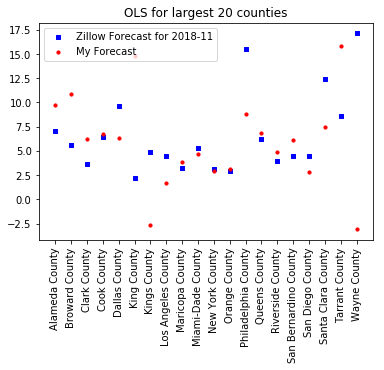

In [201]:
zillow_forecast = forecast['ForecastYoYPctChange']
xlabel = forecast['RegionName']

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(xlabel, zillow_forecast, s=10, c='b', marker="s", label='Zillow Forecast for 2018-11')
ax1.scatter(xlabel, pred_list, s=10, c='r', marker="o", label='My Forecast')
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.title('OLS for largest 20 counties')
plt.show()

### ARMA Fitting

In [4]:
p,q = 12,1
arma = ARIMA(endog =y, order=(p, q)).fit()
arma.forecast()

NameError: name 'y' is not defined

In [234]:
def predictARMA(p,q,y):
    arma = ARMA(y, order=(p, q)).fit()
    return arma.forecast()[0][0]

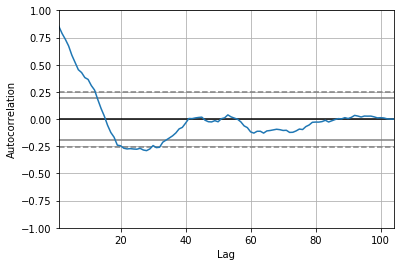

In [208]:
Y = zhvi_final.iloc[-104:,:20]
# Y.iloc[:,0]
autocorrelation_plot(Y.iloc[:,0])
plt.show()

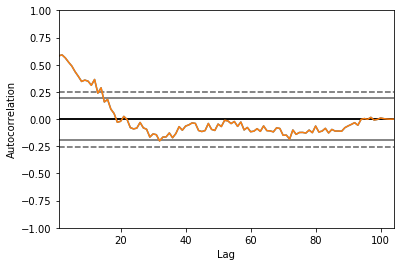

In [210]:
autocorrelation_plot(Y.iloc[:,1])
plt.show()

In [ ]:
pred_arma = [predictARMA(p,q,Y.iloc[:, i])*1000 for i in np.arange(20)]

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

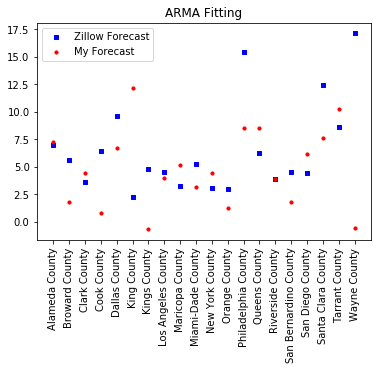

In [242]:
zillow_forecast = forecast['ForecastYoYPctChange']
xlabel = forecast['RegionName']

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(xlabel, zillow_forecast,s=10, c='b', marker="s", label='Zillow Forecast for 2018-11')
ax1.scatter(xlabel, pred_arma, s=10, c='r', marker="o", label='My Forecast')
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.title('ARMA Fitting')
plt.show()

In [241]:
np.corrcoef(zillow_forecast, pred_arma)

array([[ 1.       ,  0.0500802],
       [ 0.0500802,  1.       ]])